In [1]:
# !pip install --upgrade -q numpy numba polars lightgbm tensorflow-addons

In [2]:
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import gc
import json
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc
import os
import sys
sys.path.append('..')

from src import metric_fast
import joblib
import time
import importlib
importlib.reload(metric_fast)

2023-12-14 07:56:28.940194: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports 

<module 'src.metric_fast' from '/home/sleep-kaggle/kaggle_final_solution/../src/metric_fast.py'>

In [4]:
class cfg:
    samp_freq=1
    gaussian_overlay_len = 60
    std_dev_num = 2400
    ver='fm-v15-final'

In [ ]:
settings_json = json.load(open('../settings.json', 'r'))
print(settings_json)

for k,v in settings_json.items():
    setattr(cfg, k, v)
    
print(cfg.__dict__)

In [ ]:
%%time
train_events = pl.read_ipc(os.path.join(cfg.processed_data_path, 'train_events.ipc'))

In [5]:
splits_df = train_events[['series_id']].unique(maintain_order=True)
splits_df = splits_df.to_pandas()

for n_splits in [5, 7, 10]:
    folds = KFold(n_splits, shuffle=True, random_state=5)

    splits_df[f'{n_splits}_fold'] = 0
    for i, (trn_idx, val_idx) in enumerate(folds.split(splits_df['series_id'], splits_df['series_id'])):
        
        splits_df.loc[val_idx, f'{n_splits}_fold'] = i+1
        
        
splits_df = pl.DataFrame(splits_df)

In [6]:
def load_data(directory):
    X_s = []
    y_s = []
    series_ids = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('_X.npy'):
            series_id = filename.split('_X.npy')[0]
            X = np.load(os.path.join(directory, filename))
            y = np.load(os.path.join(directory, f'{series_id}_y.npy'))

            X_s.append(X)
            y_s.append(y)
            series_ids.append(series_id)

    return X_s, y_s, series_ids

In [7]:
def normalize_y(y):
    
    for i in range(y.shape[1]):
        
        mean = y[:,i].mean()
        std = y[:,i].std()
        y[:,i] = (y[:,i]-mean)/(std+1e-16)
    
    return y

In [8]:
def split_and_pad(X, y=None, split_length=1440, stride=1440):
    """
    Splits and pads the arrays X and y using a sliding window.

    Parameters:
    - X (np.array): Array with shape (timesteps, features)
    - y (np.array): Array with shape (timesteps, 2)
    - split_length (int): Desired timestep length for the resulting arrays.
    - stride (int): Step size for sliding window.

    Returns:
    - List of arrays for X and y, each with shape (split_length, features)
    """
    
    if y is not None and len(X) != len(y):
        raise ValueError("X and y should have the same number of timesteps.")
    
    timesteps, features = X.shape
    
    # Create empty lists to store split segments
    X_splits = []
    y_splits = []
    starts = []
    
    # Use sliding window to extract segments
    
    for start in range(0, timesteps, stride):
        end = start + split_length
        if end <= timesteps:
            starts.append(start)
            X_splits.append(X[start:end].copy())
            if y is not None:
                y_splits.append(y[start:end].copy())
        else:
            # If the segment is shorter than split_length, pad it
            starts.append(start)
            padding_length = end - timesteps
            X_segment_padded = np.pad(X[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=-9)
            X_splits.append(X_segment_padded)
            
            if y is not None:
                y_segment_padded = np.pad(y[start:], ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
                y_splits.append(y_segment_padded)
                
            break
            
            
    if y is not None:
        return X_splits, y_splits, starts
    
    return X_splits, starts



class SleepDataset:
    
    def __init__(self, X_s, y_s=None, series_ids=None, samp_freq=None, remove_no_dets=True, is_train=False, split_factor=1, norm_params=None):
        
        self.split_len = (24*60*12) // cfg.samp_freq
        self.split_strides = self.split_len
        self.remove_no_dets = remove_no_dets
        self.is_train = is_train

        print(f'Using a split len of {self.split_len}')
        self.create_dataset(X_s, y_s, series_ids)

        if self.is_train:
            self.norm_params = self.calculate_norm_params()
        else:
            if norm_params is None:
                raise ValueError("Normalization parameters must be provided for non-training data.")
            self.norm_params = norm_params

        self.normalize_data()

    def calculate_norm_params(self):
        mean = np.mean(self.X, axis=(0, 1))
        std = np.std(self.X, axis=(0, 1))
        return {'mean': mean, 'std': std}

    def normalize_data(self):
        self.X = (self.X - self.norm_params['mean']) / (1e-6 + self.norm_params['std'])
        
        
    def create_dataset(self, X_s, y_s=None, series_ids=None):
        X_s_splits, y_s_splits, series_splits, starts_splits = [], [], [], []

        for i in tqdm(range(len(X_s))):
            x_splits, starts = split_and_pad(X_s[i].copy(), split_length = self.split_len, stride=self.split_strides)
            X_s_splits.extend(x_splits)
            starts_splits.extend(starts)

            if y_s is not None:
                _, y_splits, _ = split_and_pad(X_s[i].copy(), y_s[i].copy(), split_length=self.split_len, stride=self.split_strides)
                y_s_splits.extend(y_splits)

            if series_ids is not None:
                series_splits.extend([series_ids[i] for _ in range(len(x_splits))])
            
        self.X = np.array(X_s_splits)
        self.starts_splits = np.array(starts_splits)
        
        if y_s is not None:
            self.y = np.array(y_s_splits)

            if self.remove_no_dets:
                fltr = (self.y[:, :, 1].sum(axis=1) + self.y[:, :, 0].sum(axis=1)) != 0
                self.X = self.X[fltr]
                self.y = self.y[fltr]
                if series_ids is not None:
                    self.series_ids = np.array(series_splits)[fltr]
                else:
                    self.series_ids = None
            
            self.y = np.array([normalize_y(yts) for yts in self.y])

        else:
            self.y = None

        if series_ids is not None:
            if not hasattr(self, 'series_ids'):
                self.series_ids = np.array(series_splits)
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}, series_ids: {self.series_ids.shape}')
        else:
            print(f'X: {self.X.shape}, y: {self.y.shape if self.y is not None else "Not provided"}')

In [9]:
def nms_nikhil(preds_orig, k_orig=125, max_thresh=0.05, max_count=1000):
    
    preds=preds_orig.copy()

    count = 0
    base=6.75
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
            
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 
        
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]
        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)


def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [10]:
def calculate_exponential_lr(start_lr, end_lr, num_steps, decay_rate=None):
    """
    Calculate the exponentially decreasing learning rates.

    Parameters:
    start_lr (float): Initial learning rate.
    end_lr (float): Final learning rate.
    num_steps (int): Total number of steps over which the learning rate should decay.
    decay_rate (float): Decay rate per step. If None, it will be computed based on start_lr, end_lr, and num_steps.

    Returns:
    list: A list containing the learning rate for each step.
    """
    if decay_rate is None:
        # Calculate decay rate based on the start_lr, end_lr, and num_steps
        decay_rate = (end_lr / start_lr) ** (1 / (num_steps - 1))

    learning_rates = [start_lr * (decay_rate ** step) for step in range(num_steps)]
    return learning_rates



In [11]:
class IntervalEvaluation(tf.keras.callbacks.Callback):
    def __init__(self, val_ds, val_events_df, samp_freq, n_steps, start_lr, end_lr):

        super(tf.keras.callbacks.Callback, self).__init__()
        self.val_ds = val_ds
        self.val_events_df = val_events_df
        self.samp_freq = samp_freq
        
        warmup_pct_steps = 0.25
        warmup_steps = int(n_steps * warmup_pct_steps)
        self.learning_rates = [start_lr] * (warmup_steps) + calculate_exponential_lr(start_lr, end_lr, n_steps-warmup_steps)
        self.best_score = -np.inf
        self.best_model = None
        self.step_count=0

    def on_epoch_begin(self, epoch, logs={}):

        self.start_time = time.time()
        
        if epoch == 0:
            self.first_epoch_start_time = self.start_time
        
    def on_train_batch_begin(self, batch, logs=None):
        if self.step_count < len(self.learning_rates):

            tf.keras.backend.set_value(self.model.optimizer.lr, self.learning_rates[self.step_count])
            self.curr_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.step_count += 1
    
    def on_epoch_end(self, epoch, logs={}):

        val_preds = self.model.predict(self.val_ds.X, batch_size=32, verbose=0)[:, :, :2]
        val_score = post_process_preds(self.val_events_df, val_preds, self.val_ds.series_ids, self.val_ds.starts_splits, self.samp_freq, get_score=True)
        
        if val_score > self.best_score:
            self.best_score = val_score
            self.best_model = tf.keras.models.clone_model(self.model)
            self.best_model.set_weights(self.model.get_weights()) 
        
        total_time = round(time.time() - self.start_time, 2)
        total_seconds_till_now = round(time.time() - self.first_epoch_start_time, 0)
        
        print(f"Epoch: {epoch:03d} curr_lr: {self.curr_lr:.1e} - train_loss: {logs['loss']:.04f} - val_loss: {logs['val_loss']:.04f} val_score: {val_score:.03f}  best_val_score: {self.best_score:.03f}  last_epoch t={total_time:.02f}s, total_time_elapsed t={total_seconds_till_now}s")
        

In [12]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    # MultiHead Attention
    x = tfa.layers.MultiHeadAttention(
        head_size=head_size,
        num_heads=num_heads,
        use_projection_bias=True,
        dropout=dropout
    )([inputs, inputs, inputs])

    # Residual connection with LayerNormalization and Scaling
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs) * (0.5 ** 0.5)
    
    # Feed Forward Part
    ff = tf.keras.layers.Dense(ff_dim, activation='gelu')(x)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(inputs.shape[-1])(ff)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    
    # Residual connection with LayerNormalization and Scaling for FFN
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff) * (0.5 ** 0.5)

    return x

In [13]:
def custom_mce_loss(y_true, y_pred):
    # Clip the ground truth and predictions to the range (-100, 100)
    y_true_clipped = tf.clip_by_value(y_true, -100, 100)
    y_pred_clipped = tf.clip_by_value(y_pred, -100, 100)

    # Calculate the mean cubed error
    loss = tf.reduce_mean(tf.abs(y_true_clipped - y_pred_clipped) ** 3)
    return loss

In [14]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(inputs)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters, 8, padding="same")(x)
    x = tf.keras.layers.ReLU()(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    return x, p

def decoder_block(inputs, concat_tensors, num_filters):
    x = tf.keras.layers.Conv1DTranspose(num_filters, 4, strides=2, padding="same")(inputs)
    i = len(concat_tensors)-1
    for concat_tensor in concat_tensors:
        concat_tensor_max = tf.keras.layers.MaxPool1D(pool_size=2**i)(concat_tensor)
        x = tf.keras.layers.Concatenate()([x, concat_tensor_max])
        i -= 1
        
    x = conv_block(x, num_filters)
    return x

def get_model(input_shape, num_blocks=4):
    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    
    orig_n_channels = x.shape[-1]
    
    x_t = []
    n_split_fact = 6

    for i in range(x.shape[-1]):
        x_sp = tf.reshape(x[:, :, i], (-1, x.shape[1]//n_split_fact, n_split_fact))
        
        if i < orig_n_channels:
        
            # Calculating mean, max, and standard deviation
            mean = tf.reduce_mean(x_sp, axis=-1, keepdims=True)
            max_val = tf.reduce_max(x_sp, axis=-1, keepdims=True)
            std_dev = tf.math.reduce_std(x_sp, axis=-1, keepdims=True)
            min_val = tf.reduce_min(x_sp, axis=-1, keepdims=True)

            x_sp = tf.keras.layers.Concatenate()([x_sp, mean, max_val, std_dev, min_val])
        
        x_sp = tf.keras.layers.Dense(n_split_fact*16, activation='relu')(x_sp)
        
        x_t.append(x_sp)
        
    
    x_c1d = tf.keras.layers.Conv1D(64, kernel_size=12, strides=n_split_fact, padding="same")(x)
    x_c1d = tf.keras.layers.ReLU()(x_c1d)

    x = tf.keras.layers.Concatenate()(x_t + [x_c1d])# tf.reshape(x, (-1, -1, 3))
    
    # Initial filter size
    fsz = 64
    
    # Lists to hold the encoder and pooling outputs
    encoder_outputs = []
    pooling_outputs = []
    
    # Encoder
    for i in range(num_blocks):
        if i == 0:
            # First block receives the model input
            enc_out, pool_out = encoder_block(x, fsz * (2 ** i))
        else:
            # Subsequent blocks receive the pooling output of the previous block
            enc_out, pool_out = encoder_block(pooling_outputs[-1], fsz * (2 ** i))
        
        encoder_outputs.append(enc_out)
        pooling_outputs.append(pool_out)
    
    # Bottleneck
    bottleneck = conv_block(pooling_outputs[-1], fsz * (2 ** num_blocks))
    
    
    def gru_conv(x):
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(x.shape[-1]//4, return_sequences=True))(x)
        for i in range(1):
            x_conv = tf.keras.layers.Conv1D(x.shape[-1], kernel_size=(4,), padding='same', activation='relu')(x)
            x = tf.keras.layers.Dense(x.shape[-1], activation='relu')(x_conv)

        return x
    
    for _ in range(1):
        bottleneck = transformer_encoder(bottleneck, head_size=16, num_heads=8, ff_dim=256, dropout=0)

    bottleneck = gru_conv(bottleneck)

    decoder_input = bottleneck
    for i in range(num_blocks - 1, -1, -1):
        decoder_output = decoder_block(decoder_input, encoder_outputs[:i+1], fsz * (2 ** i))
        decoder_input = decoder_output
    
    # Output Layer
    x = tf.keras.layers.Conv1D(2*n_split_fact, 1, padding="same", activation="linear")(decoder_output)
    x = tf.reshape(x, shape=(-1, x.shape[1]*n_split_fact, 2))
    
    outputs = x
    
    model = tf.keras.models.Model(inputs, outputs)
    model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=1e-4), loss=custom_mce_loss)
    
    return model

# Usage:
input_shape = (17280, 9)  # replace with your input shape
num_blocks = 4  # specify the number of encoder/decoder blocks
model = get_model(input_shape, num_blocks)
model.count_params()

2023-12-14 07:56:31.187796: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-12-14 07:56:31.315684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46413 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:23:00.0, compute capability: 8.9
/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


34620204

In [15]:
model.output.shape

TensorShape([None, 17280, 2])

In [16]:
class model_cfg:
    n_epochs = 14
    batch_size = 8
    start_lr = 6e-5
    end_lr = 2e-5

In [17]:
_ = gc.collect()

In [18]:
n_folds = 5
fold_run_order = [2, 1, 3, 4, 5]

val_preds_lst = []
val_series_lst = []
val_starts_splits_lst = []

val_y_lst = []
models_lst = []
val_scores = []

model_dct = {}

for fold_num in fold_run_order:
    
    X_s, y_s, series_ids = load_data(cfg.processed_data_path)
    

    print(f'\n\n\n-----------Starting fold: {fold_num}-----------\n\n\n')
    
    series_ids_val = splits_df.filter(pl.col(f'{n_folds}_fold') == fold_num)['series_id'].to_numpy()

    val_idxs = [series_ids.index(s) for s in series_ids_val]
    trn_idxs = np.setdiff1d(np.arange(len(series_ids)), val_idxs)
    
    print(f'Using {len(trn_idxs)} series for training and {len(val_idxs)} series for validation')

    X_s_trn, y_s_trn, series_ids_trn = [X_s[i] for i in trn_idxs], [y_s[i] for i in trn_idxs], [series_ids[i] for i in trn_idxs]
    X_s_val, y_s_val, series_ids_val = [X_s[i] for i in val_idxs], [y_s[i] for i in val_idxs], [series_ids[i] for i in val_idxs]

    trn_ds = SleepDataset(X_s_trn, y_s_trn, series_ids_trn, cfg.samp_freq, remove_no_dets=False, is_train=True)
    norm_params = trn_ds.norm_params
    model_dct[fold_num] = norm_params
    
    val_ds = SleepDataset(X_s_val, y_s_val, series_ids_val, cfg.samp_freq, remove_no_dets=False, is_train=False, norm_params=norm_params)

    del X_s_trn, y_s_trn,  X_s_val, y_s_val, series_ids_trn, X_s, y_s, series_ids
    _ = gc.collect()


    model = get_model(trn_ds.X.shape[1:])
    
    print(f'Total model parameters: {model.count_params()}')

    val_events_df = train_events.filter(pl.col('series_id').is_in(series_ids_val))
    inter_eval = IntervalEvaluation(val_ds, val_events_df, cfg.samp_freq, (trn_ds.X.shape[0]//model_cfg.batch_size)*model_cfg.n_epochs, model_cfg.start_lr, model_cfg.end_lr)
    
    model.fit(trn_ds.X, trn_ds.y,
          epochs=model_cfg.n_epochs,
          batch_size=model_cfg.batch_size,
          callbacks=[inter_eval],
          verbose=1,
          validation_data=(val_ds.X, val_ds.y))
    
    
    
    last_loss = model.history.history['val_loss'][-1]
    print(f'Model finished with val loss: {last_loss}')
    
    model = inter_eval.best_model
    val_preds = model.predict(val_ds.X)
    
    val_score = post_process_preds(val_events_df, val_preds, val_ds.series_ids, val_ds.starts_splits, cfg.samp_freq, get_score=True)
    print(f'Val Score: {val_score}')
    
    val_scores.append(val_score)
    
    val_y_lst.append(val_ds.y)
    val_preds_lst.append(val_preds)
    val_series_lst.append(val_ds.series_ids)
    val_starts_splits_lst.append(val_ds.starts_splits)
    
    tf.keras.models.save_model(model, os.path.join(cfg.output_dir, cfg.ver, f'tf_model_fold_{fold_num}.h5'))
    
    del trn_ds, val_ds, model, inter_eval
    _ = gc.collect()

avg_val_score, std_val_score = np.mean(val_scores), np.std(val_scores)
print(f'Avg val score: {avg_val_score} and std val score: {std_val_score}')

100%|██████████| 529/529 [00:04<00:00, 129.44it/s]





-----------Starting fold: 2-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:11<00:00, 18.37it/s]


X: (5742, 17280, 32), y: (5742, 17280, 2), series_ids: (5742,)
Using a split len of 17280


100%|██████████| 53/53 [00:00<00:00, 73.47it/s]


X: (1462, 17280, 32), y: (1462, 17280, 2), series_ids: (1462,)
Total model parameters: 35792652
Epoch 1/14


2023-12-14 07:57:30.447323: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-14 07:57:30.467279: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


718/718 [==============================] - 73s 93ms/step - loss: 4.4141 - val_loss: 3.5563
Epoch 2/14
718/718 [==============================] - 60s 83ms/step - loss: 3.6932 - val_loss: 3.6727
Epoch 3/14
718/718 [==============================] - 64s 89ms/step - loss: 3.5766 - val_loss: 3.4079
Epoch 4/14
718/718 [==============================] - 60s 83ms/step - loss: 3.5133 - val_loss: 3.4243
Epoch 5/14
718/718 [==============================] - 65s 90ms/step - loss: 3.4497 - val_loss: 3.3157
Epoch 6/14
718/718 [==============================] - 61s 85ms/step - loss: 3.4012 - val_loss: 3.2930
Epoch 7/14
718/718 [==============================] - 59s 82ms/step - loss: 3.3799 - val_loss: 3.4307
Epoch 8/14
718/718 [==============================] - 63s 87ms/step - loss: 3.3518 - val_loss: 3.3386
Epoch 9/14
718/718 [==============================] - 65s 91ms/step - loss: 3.3189 - val_loss: 3.2885
Epoch 10/14
718/718 [==============================] - 62s 86ms/step - loss: 3.3008 - val_los

100%|██████████| 529/529 [00:05<00:00, 100.78it/s]





-----------Starting fold: 1-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:10<00:00, 20.38it/s]


X: (5831, 17280, 32), y: (5831, 17280, 2), series_ids: (5831,)
Using a split len of 17280


100%|██████████| 53/53 [00:01<00:00, 40.71it/s]


X: (1373, 17280, 32), y: (1373, 17280, 2), series_ids: (1373,)
Total model parameters: 35792652
Epoch 1/14
729/729 [==============================] - 72s 90ms/step - loss: 4.2703 - val_loss: 3.9469
Epoch 2/14
729/729 [==============================] - 61s 84ms/step - loss: 3.5914 - val_loss: 3.7166
Epoch 3/14
729/729 [==============================] - 59s 81ms/step - loss: 3.4931 - val_loss: 3.9475
Epoch 4/14
729/729 [==============================] - 59s 81ms/step - loss: 3.4304 - val_loss: 3.6782
Epoch 5/14
729/729 [==============================] - 64s 87ms/step - loss: 3.3555 - val_loss: 3.6650
Epoch 6/14
729/729 [==============================] - 58s 80ms/step - loss: 3.3535 - val_loss: 3.5904
Epoch 7/14
729/729 [==============================] - 63s 86ms/step - loss: 3.2913 - val_loss: 3.5483
Epoch 8/14
729/729 [==============================] - 59s 81ms/step - loss: 3.2647 - val_loss: 3.6709
Epoch 9/14
729/729 [==============================] - 63s 87ms/step - loss: 3.2482 - val

100%|██████████| 529/529 [00:03<00:00, 154.61it/s]





-----------Starting fold: 3-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:08<00:00, 24.24it/s]


X: (5778, 17280, 32), y: (5778, 17280, 2), series_ids: (5778,)
Using a split len of 17280


100%|██████████| 53/53 [00:01<00:00, 32.21it/s]


X: (1426, 17280, 32), y: (1426, 17280, 2), series_ids: (1426,)
Total model parameters: 35792652
Epoch 1/14
723/723 [==============================] - 77s 98ms/step - loss: 4.4906 - val_loss: 3.8097
Epoch 2/14
723/723 [==============================] - 64s 88ms/step - loss: 3.6758 - val_loss: 3.5728
Epoch 3/14
723/723 [==============================] - 64s 89ms/step - loss: 3.5765 - val_loss: 3.7460
Epoch 4/14
723/723 [==============================] - 63s 87ms/step - loss: 3.5041 - val_loss: 3.5233
Epoch 5/14
723/723 [==============================] - 61s 85ms/step - loss: 3.4549 - val_loss: 3.5436
Epoch 6/14
723/723 [==============================] - 63s 87ms/step - loss: 3.4076 - val_loss: 3.4394
Epoch 7/14
723/723 [==============================] - 63s 88ms/step - loss: 3.3734 - val_loss: 3.3721
Epoch 8/14
723/723 [==============================] - 62s 86ms/step - loss: 3.3490 - val_loss: 3.4317
Epoch 9/14
723/723 [==============================] - 64s 88ms/step - loss: 3.3098 - val

100%|██████████| 529/529 [00:04<00:00, 106.74it/s]





-----------Starting fold: 4-----------



Using 211 series for training and 53 series for validation
Using a split len of 17280


100%|██████████| 211/211 [00:08<00:00, 24.77it/s]


X: (5820, 17280, 32), y: (5820, 17280, 2), series_ids: (5820,)
Using a split len of 17280


100%|██████████| 53/53 [00:01<00:00, 34.85it/s]


X: (1384, 17280, 32), y: (1384, 17280, 2), series_ids: (1384,)
Total model parameters: 35792652
Epoch 1/14
728/728 [==============================] - 74s 94ms/step - loss: 4.3513 - val_loss: 3.8239
Epoch 2/14
728/728 [==============================] - 62s 86ms/step - loss: 3.6691 - val_loss: 3.7467
Epoch 3/14
728/728 [==============================] - 63s 87ms/step - loss: 3.5306 - val_loss: 3.6201
Epoch 4/14
728/728 [==============================] - 63s 86ms/step - loss: 3.4921 - val_loss: 3.6033
Epoch 5/14
728/728 [==============================] - 63s 86ms/step - loss: 3.4252 - val_loss: 3.5611
Epoch 6/14
728/728 [==============================] - 63s 87ms/step - loss: 3.3720 - val_loss: 3.4848
Epoch 7/14
728/728 [==============================] - 61s 83ms/step - loss: 3.3564 - val_loss: 3.5293
Epoch 8/14
728/728 [==============================] - 61s 84ms/step - loss: 3.3104 - val_loss: 3.4593
Epoch 9/14
728/728 [==============================] - 60s 82ms/step - loss: 3.2988 - val

100%|██████████| 529/529 [00:04<00:00, 108.24it/s]





-----------Starting fold: 5-----------



Using 212 series for training and 52 series for validation
Using a split len of 17280


100%|██████████| 212/212 [00:08<00:00, 26.11it/s]


X: (5645, 17280, 32), y: (5645, 17280, 2), series_ids: (5645,)
Using a split len of 17280


100%|██████████| 52/52 [00:01<00:00, 29.16it/s]


X: (1559, 17280, 32), y: (1559, 17280, 2), series_ids: (1559,)
Total model parameters: 35792652
Epoch 1/14
706/706 [==============================] - 79s 103ms/step - loss: 4.4727 - val_loss: 3.6533
Epoch 2/14
706/706 [==============================] - 63s 90ms/step - loss: 3.7217 - val_loss: 3.5463
Epoch 3/14
706/706 [==============================] - 65s 92ms/step - loss: 3.6077 - val_loss: 3.5841
Epoch 4/14
706/706 [==============================] - 65s 92ms/step - loss: 3.5168 - val_loss: 3.3857
Epoch 5/14
706/706 [==============================] - 65s 92ms/step - loss: 3.4612 - val_loss: 3.2507
Epoch 6/14
706/706 [==============================] - 63s 89ms/step - loss: 3.4302 - val_loss: 3.2572
Epoch 7/14
706/706 [==============================] - 61s 87ms/step - loss: 3.3919 - val_loss: 3.3175
Epoch 8/14
706/706 [==============================] - 63s 89ms/step - loss: 3.3730 - val_loss: 3.3124
Epoch 9/14
706/706 [==============================] - 64s 90ms/step - loss: 3.3292 - va

###### series_ids_val

In [19]:
val_starts_splits_all = np.concatenate(val_starts_splits_lst)
val_preds_all = np.concatenate(val_preds_lst)
val_series_all = np.concatenate(val_series_lst)
val_y_all = np.concatenate(val_y_lst)

print(val_preds_all.shape, val_y_all.shape, val_series_all.shape)

(7204, 17280, 2) (7204, 17280, 2) (7204,)


In [20]:
# The code is creating a DataFrame `oof_preds_df` that contains the predicted values for the "onset" and "wakeup" columns.

res_steps = []
res_preds_onsets = []
res_preds_wakeups = []

res_series_ids = []

start = 0
while start < len(val_preds_all):
    
    end = start+1
    while end < len(val_preds_all) and val_series_all[end] == val_series_all[start]:
        end += 1
        
    preds = val_preds_all[start:end]
    
    steps = np.concatenate([val_starts_splits_all[idx] + np.arange(len(val_preds_all[idx])) for idx in range(start, end)])
    preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
    
    res_preds_onsets.append(preds[:, 0])
    res_preds_wakeups.append(preds[:, 1])
    
    res_steps.append(steps)
    ser_id = val_series_all[start]
    
    res_series_ids.append([ser_id for _ in range(len(preds))])
    
    start=end
    
    
oof_preds_df = pl.DataFrame().with_columns([
    pl.Series(np.concatenate(res_series_ids)).alias('series_id'),
    pl.Series(np.concatenate(res_steps)).alias('step'),
    pl.Series(np.concatenate(res_preds_onsets)).alias('onset'),
    pl.Series(np.concatenate(res_preds_wakeups)).alias('wakeup')

])

train_series = pl.read_parquet(cfg.train_series_path)
print(train_series.shape)
train_series = train_series.filter(pl.col('series_id').is_in(list(np.unique(val_series_all))))
train_series = train_series.with_columns(pl.col('step').cast(pl.Int64))
print(train_series.shape)



print(oof_preds_df.shape)
oof_preds_df = train_series[['series_id', 'step']].join(oof_preds_df, on=['series_id', 'step'], how='left')
print(oof_preds_df.shape)

oof_preds_df.write_parquet(os.path.join(cfg.output_dir, cfg.ver, 'oof_preds.parquet'))

(127946340, 5)
(122539680, 5)
(124485120, 4)
(122539680, 4)


In [21]:
# !rm -r ../data_processed/{cfg.ver}

03d92c9f6f8a


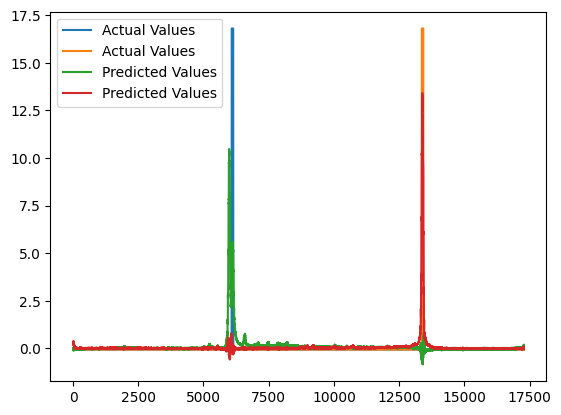

In [22]:
i = 2
# sid = val_series_all.filter(pl.col())
plt.plot(val_y_all[i], label="Actual Values")
print(val_series_all[i])

plt.plot(val_preds_all[i], label="Predicted Values")


plt.legend()
plt.show()

In [23]:
def nms_nikhil(preds_orig, k_orig=150, max_thresh=0.1, max_count=1000):
    
    preds=preds_orig.copy()
    preds = np.convolve(preds, np.array([0.15, 0.7, 0.15]), mode='same')

    count = 0
    orig_base=8
    
    k = k_orig
    prev_max = None

    scores = []
    indices = []
    
    while True:
        base = orig_base
        
        supress_k = 20
        curr_max_idx = np.argmax(preds)
        curr_max = preds[curr_max_idx] 

        if curr_max >= 16:
            k = 300   
            orig_base = 18
            supress_k = 20
        
        elif curr_max >= 15:
            k = 250   
            orig_base = 15
            supress_k = 20
        
        elif curr_max >= 14:
            k = 225
            orig_base = 12
            supress_k = 20
            
        elif curr_max >= 12:
            k = 210
            orig_base = 10
            supress_k = 20
        
        elif curr_max > 10:
            k = 190
            orig_base = 7
        
        elif curr_max > 8:
            k = 175
            orig_base = 6
            
        elif curr_max > 4:
            k = 150
            orig_base = 5
            
        elif curr_max >= 2:
            k = 120
            orig_base = 4.5
            
        elif curr_max >= 1:
            k = 80
            orig_base = 4
            
        elif curr_max >= 0.2:
            k = 40
            orig_base = 3
        else:
            k = 30
            orig_base = 2
            
        if (curr_max < max_thresh) or count > max_count:
            break
        
        indices.append(curr_max_idx)
        scores.append(curr_max)
        
        preds[curr_max_idx] = 0
        
        supress_rates = np.logspace(start=0, stop=1, num=k, base=base)/base
        supress_rates[:supress_k] = 0
        # supress_rates[20:] += 0.1

        preds[max(curr_max_idx-k, 0):curr_max_idx] *= supress_rates[:min(k, curr_max_idx-0)][::-1]

        preds[curr_max_idx+1:min(curr_max_idx+k+1, preds.shape[0])] *= supress_rates[:min(k, preds.shape[0]-curr_max_idx-1)]

        prev_max = curr_max
        
        count += 1
        
    return indices, scores

def get_actual_preds(val_preds, val_series_ids, val_steps, type_):
    times = []
    series_ids = []
    scores = []
    scores_y = []
    
    for i in np.arange(len(val_preds)):
        
        vp_i = val_preds[i]
        ser_id = val_series_ids[i]
        
        col_index = 0 if type_ == "onset" else 1
        other_col_index = 1 if type_ == "onset" else 0
        
        preds = vp_i[:, col_index]
        preds_other = vp_i[:, other_col_index]

        height_thresh = 0.05
        
        peaks, peak_scores = nms_nikhil(preds)

        times.extend(val_steps[i][peaks])
        scores.extend(list(peak_scores))
        series_ids.extend([ser_id] * len(peaks))

    return np.array(series_ids), np.array(times), np.array(scores)




def post_process_preds(val_events_df, val_preds, val_series_ids, val_starts_splits, samp_freq, get_score=False):
    
#     val_steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(val_preds.shape[0])])

    val_res = []
    
    prev_ser_id = None
    
    res_steps = []
    res_preds = []
    res_series_ids = []
    
    start = 0
    while start < len(val_preds):
        
        end = start+1
        while end < len(val_preds) and val_series_ids[end] == val_series_ids[start]:
            end += 1
            
        preds = val_preds[start:end]
        
        steps = np.concatenate([val_starts_splits[idx] + np.arange(len(val_preds[idx])) for idx in range(start, end)])
        preds = preds.reshape((preds.shape[0]*preds.shape[1]), 2)
        
        res_preds.append(preds)
        res_steps.append(steps)
        res_series_ids.append(val_series_ids[start])
        
        start=end
        
        
#     print(len(res_series_ids), len(res_steps), len(res_preds))

    series_ids_onsets, onsets,  scores_onsets = get_actual_preds(res_preds, res_series_ids, res_steps, 'onset')
    series_ids_wakeups, wakeups,  scores_wakeups =get_actual_preds(res_preds, res_series_ids, res_steps, 'wakeup')
    
    
    onset_preds = pl.DataFrame().with_columns([pl.Series(series_ids_onsets).alias('series_id'),
                                           pl.Series(onsets).cast(pl.Int64).alias('step'),
                                           pl.lit('onset').alias('event'),
                                           pl.Series(scores_onsets).alias('score')])

    wakeup_preds = pl.DataFrame().with_columns([pl.Series(series_ids_wakeups).alias('series_id'),
                                               pl.Series(wakeups).cast(pl.Int64).cast(pl.Int64).alias('step'),
                                               pl.lit('wakeup').alias('event'),
                                               pl.Series(scores_wakeups).alias('score')])
    
    val_preds_df = pl.concat([onset_preds, wakeup_preds]).sort(by=['series_id', 'step'])
    print(val_preds_df.shape, end=' ')
    
    if get_score:
        toleranaces = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}
        comp_score = metric_fast.comp_scorer(
        val_events_df,
        val_preds_df,
        tolerances = toleranaces,
        )
        return comp_score
    
    else:
        return val_preds_df

In [24]:
%%time
scores = []

for fold_num in range(1, 5+1):
    
    test_ser_ids = list(np.unique(val_series_lst[fold_num-1]))


    val_events_df = train_events.filter(pl.col('series_id').is_in(test_ser_ids))
    score = post_process_preds(val_events_df,
                               val_preds_lst[fold_num-1],
                               val_series_lst[fold_num-1],
                               val_starts_splits_lst[fold_num-1],
                               cfg.samp_freq,
                               get_score=True)
    print(score)
    scores.append(score)
    
np.mean(scores), np.std(scores)

(98191, 4) 0.8090413455380376
(103571, 4) 0.8255364502605911
(104647, 4) 0.8243587294606393
(92868, 4) 0.8148486436146469
(102604, 4) 0.824185073542435
CPU times: user 1min, sys: 39.9 s, total: 1min 40s
Wall time: 1min 39s


(0.81959404848327, 0.0065264115961309295)

In [25]:
val_preds_df = post_process_preds(val_events_df, val_preds_all, val_series_all, val_starts_splits_all, cfg.samp_freq, get_score=False)

(501881, 4) 

In [26]:
def round_to_nearest_multiple(df, column_name='step'):
    df[column_name] = df[column_name].apply(lambda x: x+1 if x%12==0  else x)
    return df


In [27]:
val_preds_df = round_to_nearest_multiple(val_preds_df.to_pandas())
val_preds_df = pl.DataFrame(val_preds_df)

In [28]:
tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

In [29]:
metric_fast.comp_scorer(train_events, val_preds_df, tolerances=tolerances)

0.8161625023973504

In [30]:
val_preds_df.shape

(501881, 4)

In [31]:
preds_partitions  = val_preds_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)
events_partitions  = val_events_df.partition_by(by=['series_id'], maintain_order=True, as_dict=True)

tolerances = {'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
               'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]}

scores_dict = {}
for ser_id in tqdm(events_partitions.keys()):
    scores_dict[ser_id] = metric_fast.comp_scorer(events_partitions[ser_id], preds_partitions[ser_id],
                                                  tolerances)
    

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:12<00:00,  4.25it/s]


In [32]:
pd.Series(scores_dict).sort_values()

f56824b503a0    0.085576
854206f602d0    0.390577
703b5efa9bc1    0.567381
0a96f4993bd7    0.587142
6ca4f4fca6a2    0.616823
280e08693c6d    0.648960
1762ab70ec76    0.723442
cf13ed7e457a    0.725000
72bbd1ac3edf    0.764289
ccdee561ee5d    0.778035
dfc3ccebfdc9    0.808320
0402a003dae9    0.808367
8b8b9e29171c    0.808392
a167532acca2    0.817819
038441c925bb    0.817928
6bf95a3cf91c    0.818692
694faf956ebf    0.827259
b84960841a75    0.831605
fe90110788d2    0.834450
91cb6c98201f    0.843056
3d53bfea61d6    0.843383
51b23d177971    0.844073
483d6545417f    0.849707
c38707ef76df    0.866309
d2d6b9af0553    0.868193
f88e18cb4100    0.868923
a81f4472c637    0.881591
ce85771a714c    0.886299
d150801f3145    0.891119
e0d7b0dcf9f3    0.891239
ebd76e93ec7d    0.894720
8898e6db816d    0.898577
b7188813d58a    0.900307
062cae666e2a    0.902381
91127c2b0e60    0.904921
d043c0ca71cd    0.906928
18b61dd5aae8    0.908136
1955d568d987    0.909878
40dce6018935    0.910843
72d2234e84e4    0.911787


In [33]:
cfg_attributes_dict = {k: v for k, v in cfg.__dict__.items() if not k.startswith('__') and not callable(v)}
joblib.dump(cfg_attributes_dict, os.path.join(cfg.output_dir, cfg.ver, 'cfg.pkl'))
joblib.dump(model_dct, os.path.join(cfg.output_dir, cfg.ver, 'model_dct.pkl'))

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_series_all.npy'), val_series_all)


val_preds_df.to_pandas().to_csv(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_df.csv'), index=False)

np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [34]:
import json

meta_json = {
  "title": f"sleep-model-{cfg.ver}",
  "id": f"nikhilmishradev/sleep-model-{cfg.ver}",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}

json.dump(meta_json, open(os.path.join(cfg.output_dir, cfg.ver, 'dataset-metadata.json'), 'w'))

In [36]:
# !rm -r ../outputs/vx/*
# !cp -r {os.path.join(cfg.output_dir, cfg.ver)}/* ../outputs/vx
# !rm ../outputs/vx/val_preds_all.npy ../outputs/vx/val_y_all.npy
# !pip install -q kaggle
# !kaggle datasets create -p ../outputs/vx

Skipping folder: .ipynb_checkpoints; use '--dir-mode' to upload folders
Starting upload for file cfg.pkl
100%|███████████████████████████████████████████| 119/119 [00:01<00:00, 59.9B/s]
Upload successful: cfg.pkl (119B)
Starting upload for file model_dct.pkl
100%|████████████████████████████████████████| 1.99k/1.99k [00:02<00:00, 957B/s]
Upload successful: model_dct.pkl (2KB)
Starting upload for file oof_preds.parquet
100%|██████████████████████████████████████| 1.03G/1.03G [00:59<00:00, 18.5MB/s]
Upload successful: oof_preds.parquet (1GB)
Starting upload for file tf_model_fold_1.h5
100%|████████████████████████████████████████| 137M/137M [00:18<00:00, 7.79MB/s]
Upload successful: tf_model_fold_1.h5 (137MB)
Starting upload for file tf_model_fold_2.h5
100%|████████████████████████████████████████| 137M/137M [00:11<00:00, 12.8MB/s]
Upload successful: tf_model_fold_2.h5 (137MB)
Starting upload for file tf_model_fold_3.h5
100%|████████████████████████████████████████| 137M/137M [00:10<00:0

In [37]:
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_preds_all.npy'), val_preds_all)
np.save(os.path.join(cfg.output_dir, cfg.ver, 'val_y_all.npy'), val_y_all)

In [38]:
cfg.ver

'fm-v15-final'